In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import unicodedata
from pathlib import Path
!pip install scikit-learn==1.3.0

import os

!pip install catboost
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
!pip install category_encoders
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
!pip install optuna
import optuna

from sklearn.preprocessing import TargetEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


In [15]:
INPUT_DIR = '/content/drive/MyDrive/signate/Student Cup 2023/input'

df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
df

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054


In [16]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sub_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "price"])

In [17]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
  def fit(self, X, y=None):
    return self

  def transform(self, X):
    # X["title_status"] = X["title_status"].fillna("clean")

    # cylinderから数値を取り出す
    X["cylinders"] = X["cylinders"].astype(str).str.extract("(\d+)").astype("float32")

    # sizeの表記揺れを修正
    X["size"] = X["size"].str.replace("ー", "-").astype(str)
    X["size"] = X["size"].str.replace("−", "-").astype(str)

    # 順位付け: サイズ別に値を割り当てます。大きいほど高い値にします。
    ranking_dict = {'full-size': 4, 'mid-size': 3, 'compact': 2, 'sub-compact': 1}

    # 新しい順位カラムを作成します。
    X['size_rank'] = X['size'].map(ranking_dict)

    # manufacturerの表記揺れを修正
    X["manufacturer"] = X["manufacturer"].apply(
        lambda x: unicodedata.normalize("NFKC", x).lower()
    )

    # yearが3000年以降のものはおかしいので2000年に置換
    err_idx = X.query("year >= 3000").index
    X.loc[err_idx, "year"] = X.loc[err_idx, "year"].apply(lambda x: x - 1000)

    # 走行距離 / 製造年
    X["odometer_per_year"] = X["odometer"] / (2023 - X["year"])

    return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")

        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols

In [18]:
numeric_cols = ["year", "odometer", "odometer_per_year", "size_rank"]
categorical_cols = [
     'region',
    "cylinders",
    "manufacturer",
    "condition",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            categorical_cols + numeric_cols,
        ),
        (
            "tgt",
            TargetEncoder(target_type="continuous", random_state=88),
            [
                'region',
                "cylinders",
                "manufacturer",
                "condition",
                "fuel",
                "title_status",
                "transmission",
                "drive",
                "size",
                "type",
                "paint_color",
                "state",
            ],
        ),
        # *[
        #     (f"agg_{key}", AggTransformer(key, ["odometer"], {"mean"}), [key] + ["odometer"])
        #     for key in [
        #         "manufacturer",
        #     ]
        # ],
    ],
    verbose=True,
)
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ("ct", ct),
    ]
)
train_feat_df = pipe.fit_transform(train_df, train_df["price"])
test_feat_df = pipe.transform(test_df)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.1s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.3s


In [19]:
train_feat_df.sample(5)

,ori__year,ori__odometer,ori__odometer_per_year,ori__size_rank,ori__region,ori__cylinders,ori__manufacturer,ori__condition,ori__fuel,ori__title_status,...,tgt__manufacturer,tgt__condition,tgt__fuel,tgt__title_status,tgt__transmission,tgt__drive,tgt__size,tgt__type,tgt__paint_color,tgt__state
21728,2020.0,5983.0,1994.333374,2.0,austin,4.0,volkswagen,excellent,gas,clean,...,7881.819279,14665.686916,12225.230115,13260.692408,12061.623432,9767.198243,8823.639157,9909.946582,14743.384276,12395.068985
6462,2013.0,77418.0,7741.799805,4.0,san antonio,8.0,ford,excellent,gas,clean,...,14783.551297,14633.535038,12296.169311,13281.015002,13911.803726,15985.487131,15374.968508,14203.857031,16949.137716,12632.762489
6239,2015.0,16377.0,2047.125000,4.0,grand rapids,8.0,chevrolet,excellent,gas,clean,...,14834.987536,14665.686916,12225.230115,13260.692408,13930.228325,18671.671152,15394.279395,20307.656480,14743.384276,14654.021092
19029,2014.0,62093.0,6899.222168,4.0,central NJ,6.0,ford,like new,gas,clean,...,14783.551297,16489.638789,12296.169311,13281.015002,13911.803726,9806.656753,15374.968508,20207.255197,16949.137716,12279.422224
14908,2012.0,162947.0,14813.363281,4.0,tuscaloosa,4.0,bmw,good,gas,clean,...,13928.656058,10971.909137,12225.230115,13260.692408,13930.228325,9767.198243,15394.279395,13790.471227,14743.384276,12141.105247


In [20]:
def get_cv(df, n_fold=5):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

# ref: https://www.guruguru.science/competitions/16/discussions/185c7dc6-5e3a-49c6-9c30-41bf007cc694/
def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgb.LGBMRegressor(**params)
        model.fit(
            x_train,
            y_train,
            categorical_feature=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            callbacks=[lgb.early_stopping(100, verbose=verbose)],
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


def fit_cat(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    oof_pred = np.zeros((n_records,), dtype=np.float32)

    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = cb.CatBoostRegressor(**params)
        model.fit(
            x_train,
            y_train,
            cat_features=categorical_cols,
            eval_set=[(x_valid, y_valid)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=verbose,
        )
        pred_i = model.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(model)
        score = mean_absolute_percentage_error(y_valid, pred_i)
        print(f" - fold{i + 1} - {score:.4f}")

    score = mean_absolute_percentage_error(y, oof_pred)

    print("=" * 50)
    print(f"FINISHI: Whole Score: {score:.4f}")
    return score, oof_pred, models


# optunaを使ったパラメータチューニング
def tuning(train_feat_df, train_df, cv):
    def objective(trial):
        max_depth = trial.suggest_int("max_depth", 1, 10)
        num_leaves = trial.suggest_int("num_leaves", 2, 2**max_depth)
        colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
        subsample = trial.suggest_uniform("subsample", 0.1, 1.0)

        params = {
            "objective": "mape",
            "n_estimators": 10000,
            "learning_rate": 0.05,
            "max_depth": max_depth,
            "num_leaves": num_leaves,
            "colsample_bytree": colsample_bytree,
            "subsample": subsample,
            "metric": "mape",
            "importance_type": "gain",
            "random_state": 88,
        }

        score, _, _ = fit_lgbm(
            train_feat_df, train_df["price"], cv=cv, categorical_cols=[], params=params, verbose=-1
        )
        return score

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100)
    print("Number of finished trials:", len(study.trials))
    print("Best trial:", study.best_trial.params)
    return study.best_trial.params


def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax

In [21]:
n_fold = 5
lgbm_params = {
    "objective": "mape",
    "metrics": "mape",
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "max_depth": 6,
    "num_leaves": 64,
    "colsample_bytree": 0.446,
    "subsample": 0.339,
    "importance_type": "gain",
    "random_state": 88,
}


feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_cv(train_feat_df, n_fold=5)

# 既存のlgbm_paramsをtuning関数でチューニング
lgbm_params = tuning(train_feat_df, train_df, cv)

# training
score, oof, models = fit_lgbm(
    train_feat_df,
    y=train_df["price"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

# inference
pred = np.array([model.predict(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)

# submission
sub_df["price"] = pred
sub_df.to_csv("submission-009.csv", index=False, header=False)

[I 2023-08-09 13:10:19,376] A new study created in memory with name: no-name-31ea704d-da9a-461c-bdca-1c2d352fffd3
<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorica

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[985]	valid_0's mape: 0.454929
 - fold1 - 0.4549


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[694]	valid_0's mape: 0.445563
 - fold2 - 0.4456
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[481]	valid_0's mape: 0.449059
 - fold3 - 0.4491
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[840]	valid_0's mape: 0.451448
 - fold4 - 0.4514
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:10:59,214] Trial 0 finished with value: 0.44925116838694606 and parameters: {'max_depth': 2, 'num_leaves': 4, 'colsample_bytree': 0.83690048209054, 'subsample': 0.47999041114742913}. Best is trial 0 with value: 0.44925116838694606.


Early stopping, best iteration is:
[1123]	valid_0's mape: 0.445256
 - fold5 - 0.4453
FINISHI: Whole Score: 0.4493


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1278]	valid_0's mape: 0.454709
 - fold1 - 0.4547


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1369]	valid_0's mape: 0.444039
 - fold2 - 0.4440


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1127]	valid_0's mape: 0.447636
 - fold3 - 0.4476


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[815]	valid_0's mape: 0.450735
 - fold4 - 0.4507


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:11:39,313] Trial 1 finished with value: 0.4481067496379688 and parameters: {'max_depth': 7, 'num_leaves': 6, 'colsample_bytree': 0.5656511013490864, 'subsample': 0.639922260996213}. Best is trial 1 with value: 0.4481067496379688.


Early stopping, best iteration is:
[1251]	valid_0's mape: 0.443413
 - fold5 - 0.4434
FINISHI: Whole Score: 0.4481


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2128]	valid_0's mape: 0.455492
 - fold1 - 0.4555
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1069]	valid_0's mape: 0.445046
 - fold2 - 0.4450


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[905]	valid_0's mape: 0.448309
 - fold3 - 0.4483


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1174]	valid_0's mape: 0.45133
 - fold4 - 0.4513


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:12:33,529] Trial 2 finished with value: 0.44910629161366106 and parameters: {'max_depth': 2, 'num_leaves': 4, 'colsample_bytree': 0.9814717130628582, 'subsample': 0.1837178221579971}. Best is trial 1 with value: 0.4481067496379688.


Early stopping, best iteration is:
[1186]	valid_0's mape: 0.445354
 - fold5 - 0.4454
FINISHI: Whole Score: 0.4491


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[421]	valid_0's mape: 0.452899
 - fold1 - 0.4529
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[151]	valid_0's mape: 0.441168
 - fold2 - 0.4412
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[140]	valid_0's mape: 0.446401
 - fold3 - 0.4464
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[245]	valid_0's mape: 0.448664
 - fold4 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[419]	valid_0's mape: 0.441083


[I 2023-08-09 13:12:50,976] Trial 3 finished with value: 0.44604289743071945 and parameters: {'max_depth': 8, 'num_leaves': 71, 'colsample_bytree': 0.899868361774141, 'subsample': 0.21857832053017576}. Best is trial 3 with value: 0.44604289743071945.


 - fold5 - 0.4411
FINISHI: Whole Score: 0.4460
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[231]	valid_0's mape: 0.451708
 - fold1 - 0.4517


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]	valid_0's mape: 0.440843
 - fold2 - 0.4408


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	valid_0's mape: 0.447469
 - fold3 - 0.4475


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	valid_0's mape: 0.446877
 - fold4 - 0.4469


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:13:04,145] Trial 4 finished with value: 0.4456504258824877 and parameters: {'max_depth': 8, 'num_leaves': 104, 'colsample_bytree': 0.6774986671492708, 'subsample': 0.8629596985585267}. Best is trial 4 with value: 0.4456504258824877.


Early stopping, best iteration is:
[264]	valid_0's mape: 0.441355
 - fold5 - 0.4414
FINISHI: Whole Score: 0.4457


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	valid_0's mape: 0.452078
 - fold1 - 0.4521


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[140]	valid_0's mape: 0.44145
 - fold2 - 0.4414


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[204]	valid_0's mape: 0.447059
 - fold3 - 0.4471


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's mape: 0.446516
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:13:16,498] Trial 5 finished with value: 0.4457395120333216 and parameters: {'max_depth': 8, 'num_leaves': 146, 'colsample_bytree': 0.7882279144195956, 'subsample': 0.3969521309131293}. Best is trial 4 with value: 0.4456504258824877.


Early stopping, best iteration is:
[158]	valid_0's mape: 0.441595
 - fold5 - 0.4416
FINISHI: Whole Score: 0.4457


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1799]	valid_0's mape: 0.469893
 - fold1 - 0.4699
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1575]	valid_0's mape: 0.45725
 - fold2 - 0.4573


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2700]	valid_0's mape: 0.463096
 - fold3 - 0.4631
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1712]	valid_0's mape: 0.463918
 - fold4 - 0.4639


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3667]	valid_0's mape: 0.45652


[I 2023-08-09 13:14:30,473] Trial 6 finished with value: 0.462135456920519 and parameters: {'max_depth': 1, 'num_leaves': 2, 'colsample_bytree': 0.5760691099539004, 'subsample': 0.4624983426714444}. Best is trial 4 with value: 0.4456504258824877.


 - fold5 - 0.4565
FINISHI: Whole Score: 0.4621
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[312]	valid_0's mape: 0.456635
 - fold1 - 0.4566
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[224]	valid_0's mape: 0.449333
 - fold2 - 0.4493
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[309]	valid_0's mape: 0.457487
 - fold3 - 0.4575
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[309]	valid_0's mape: 0.453815
 - fold4 - 0.4538
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[469]	valid_0's mape: 0.44991


[I 2023-08-09 13:14:47,439] Trial 7 finished with value: 0.45343579984037935 and parameters: {'max_depth': 10, 'num_leaves': 727, 'colsample_bytree': 0.13769997216243685, 'subsample': 0.19490799897049568}. Best is trial 4 with value: 0.4456504258824877.


 - fold5 - 0.4499
FINISHI: Whole Score: 0.4534
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[653]	valid_0's mape: 0.449749
 - fold1 - 0.4497
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[463]	valid_0's mape: 0.4403
 - fold2 - 0.4403
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[506]	valid_0's mape: 0.446937
 - fold3 - 0.4469
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[477]	valid_0's mape: 0.446047
 - fold4 - 0.4460
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[532]	valid_0's mape: 0.441138


[I 2023-08-09 13:15:05,245] Trial 8 finished with value: 0.44483414137157384 and parameters: {'max_depth': 6, 'num_leaves': 48, 'colsample_bytree': 0.18529526363393822, 'subsample': 0.18289226920589097}. Best is trial 8 with value: 0.44483414137157384.


 - fold5 - 0.4411
FINISHI: Whole Score: 0.4448


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1697]	valid_0's mape: 0.469577
 - fold1 - 0.4696


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1428]	valid_0's mape: 0.457328
 - fold2 - 0.4573


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2917]	valid_0's mape: 0.463102
 - fold3 - 0.4631
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1456]	valid_0's mape: 0.46397
 - fold4 - 0.4640


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:16:02,720] Trial 9 finished with value: 0.4623377657274318 and parameters: {'max_depth': 1, 'num_leaves': 2, 'colsample_bytree': 0.7298008335606889, 'subsample': 0.2817676389627737}. Best is trial 8 with value: 0.44483414137157384.


Early stopping, best iteration is:
[1428]	valid_0's mape: 0.45771
 - fold5 - 0.4577
FINISHI: Whole Score: 0.4623


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[779]	valid_0's mape: 0.452071
 - fold1 - 0.4521


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	valid_0's mape: 0.441538
 - fold2 - 0.4415
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[443]	valid_0's mape: 0.447157
 - fold3 - 0.4472


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[468]	valid_0's mape: 0.44846
 - fold4 - 0.4485
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:16:23,256] Trial 10 finished with value: 0.4461955053650674 and parameters: {'max_depth': 4, 'num_leaves': 11, 'colsample_bytree': 0.2724785636464443, 'subsample': 0.10472716898486825}. Best is trial 8 with value: 0.44483414137157384.


Early stopping, best iteration is:
[622]	valid_0's mape: 0.441752
 - fold5 - 0.4418
FINISHI: Whole Score: 0.4462


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's mape: 0.451248
 - fold1 - 0.4512


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's mape: 0.439472
 - fold2 - 0.4395


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	valid_0's mape: 0.444322
 - fold3 - 0.4443
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[547]	valid_0's mape: 0.446299
 - fold4 - 0.4463


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:16:38,427] Trial 11 finished with value: 0.4442897465468492 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.3100963146624061, 'subsample': 0.9263460146215349}. Best is trial 11 with value: 0.4442897465468492.


Early stopping, best iteration is:
[425]	valid_0's mape: 0.440107
 - fold5 - 0.4401
FINISHI: Whole Score: 0.4443


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[805]	valid_0's mape: 0.450633
 - fold1 - 0.4506
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[292]	valid_0's mape: 0.439609
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[312]	valid_0's mape: 0.444378
 - fold3 - 0.4444
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[439]	valid_0's mape: 0.446468
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[799]	valid_0's mape: 0.440323


[I 2023-08-09 13:16:56,936] Trial 12 finished with value: 0.44428189972767956 and parameters: {'max_depth': 5, 'num_leaves': 22, 'colsample_bytree': 0.3383529166023225, 'subsample': 0.9952603463493492}. Best is trial 12 with value: 0.44428189972767956.


 - fold5 - 0.4403
FINISHI: Whole Score: 0.4443
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[593]	valid_0's mape: 0.450711
 - fold1 - 0.4507


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[454]	valid_0's mape: 0.439371
 - fold2 - 0.4394


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.445033
 - fold3 - 0.4450
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[332]	valid_0's mape: 0.445932
 - fold4 - 0.4459
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:17:15,909] Trial 13 finished with value: 0.444203286469366 and parameters: {'max_depth': 4, 'num_leaves': 15, 'colsample_bytree': 0.3643237371246754, 'subsample': 0.9963672413078478}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[606]	valid_0's mape: 0.439969
 - fold5 - 0.4400
FINISHI: Whole Score: 0.4442


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[904]	valid_0's mape: 0.452279
 - fold1 - 0.4523
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[348]	valid_0's mape: 0.441073
 - fold2 - 0.4411
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[983]	valid_0's mape: 0.445322
 - fold3 - 0.4453
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[311]	valid_0's mape: 0.447814
 - fold4 - 0.4478
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:17:38,852] Trial 14 finished with value: 0.4458008918429598 and parameters: {'max_depth': 4, 'num_leaves': 11, 'colsample_bytree': 0.40229179105639284, 'subsample': 0.9792414080322671}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[517]	valid_0's mape: 0.442516
 - fold5 - 0.4425
FINISHI: Whole Score: 0.4458


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[745]	valid_0's mape: 0.450994
 - fold1 - 0.4510


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[596]	valid_0's mape: 0.441165
 - fold2 - 0.4412


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's mape: 0.445022
 - fold3 - 0.4450
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[219]	valid_0's mape: 0.447485
 - fold4 - 0.4475
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:17:56,953] Trial 15 finished with value: 0.4452337599939747 and parameters: {'max_depth': 4, 'num_leaves': 13, 'colsample_bytree': 0.4296391940213123, 'subsample': 0.8204097132912758}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[657]	valid_0's mape: 0.441502
 - fold5 - 0.4415
FINISHI: Whole Score: 0.4452


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1591]	valid_0's mape: 0.453192
 - fold1 - 0.4532
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1298]	valid_0's mape: 0.44277
 - fold2 - 0.4428


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[559]	valid_0's mape: 0.447444
 - fold3 - 0.4474
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[830]	valid_0's mape: 0.450545
 - fold4 - 0.4505


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:18:32,194] Trial 16 finished with value: 0.4474665901675136 and parameters: {'max_depth': 3, 'num_leaves': 6, 'colsample_bytree': 0.4282493342037429, 'subsample': 0.747165188376347}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[870]	valid_0's mape: 0.443382
 - fold5 - 0.4434
FINISHI: Whole Score: 0.4475


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's mape: 0.451957
 - fold1 - 0.4520


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[546]	valid_0's mape: 0.440407
 - fold2 - 0.4404


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[526]	valid_0's mape: 0.446889
 - fold3 - 0.4469


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[603]	valid_0's mape: 0.446284
 - fold4 - 0.4463
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[629]	valid_0's mape: 0.440952
 - fold5 - 0.4410


[I 2023-08-09 13:18:50,648] Trial 17 finished with value: 0.44529792144957653 and parameters: {'max_depth': 6, 'num_leaves': 23, 'colsample_bytree': 0.25484073894840076, 'subsample': 0.9682870196409671}. Best is trial 13 with value: 0.444203286469366.


FINISHI: Whole Score: 0.4453
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[755]	valid_0's mape: 0.451254
 - fold1 - 0.4513
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[417]	valid_0's mape: 0.439084
 - fold2 - 0.4391
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[334]	valid_0's mape: 0.444392
 - fold3 - 0.4444
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[609]	valid_0's mape: 0.447853
 - fold4 - 0.4479


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:19:10,178] Trial 18 finished with value: 0.4447453598692966 and parameters: {'max_depth': 5, 'num_leaves': 20, 'colsample_bytree': 0.3686449281138191, 'subsample': 0.9956620122830212}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[259]	valid_0's mape: 0.441142
 - fold5 - 0.4411
FINISHI: Whole Score: 0.4447
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1035]	valid_0's mape: 0.454313
 - fold1 - 0.4543


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1136]	valid_0's mape: 0.442
 - fold2 - 0.4420


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[900]	valid_0's mape: 0.44768
 - fold3 - 0.4477


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[613]	valid_0's mape: 0.450605
 - fold4 - 0.4506
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:19:41,120] Trial 19 finished with value: 0.44760164129408164 and parameters: {'max_depth': 3, 'num_leaves': 6, 'colsample_bytree': 0.47753120692696405, 'subsample': 0.7417468686751527}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[1056]	valid_0's mape: 0.44341
 - fold5 - 0.4434
FINISHI: Whole Score: 0.4476


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[283]	valid_0's mape: 0.457381
 - fold1 - 0.4574
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[186]	valid_0's mape: 0.448773
 - fold2 - 0.4488
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[300]	valid_0's mape: 0.454547
 - fold3 - 0.4545
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[300]	valid_0's mape: 0.450572
 - fold4 - 0.4506
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[304]	valid_0's mape: 0.447738


[I 2023-08-09 13:19:59,534] Trial 20 finished with value: 0.4518023526271044 and parameters: {'max_depth': 10, 'num_leaves': 265, 'colsample_bytree': 0.2062195788308328, 'subsample': 0.8922173233459478}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4477
FINISHI: Whole Score: 0.4518
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[592]	valid_0's mape: 0.450886
 - fold1 - 0.4509
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[417]	valid_0's mape: 0.440801
 - fold2 - 0.4408


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	valid_0's mape: 0.446826
 - fold3 - 0.4468


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's mape: 0.446001
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:20:19,258] Trial 21 finished with value: 0.4451574608169771 and parameters: {'max_depth': 5, 'num_leaves': 23, 'colsample_bytree': 0.30158275899709774, 'subsample': 0.9133933405690607}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[361]	valid_0's mape: 0.441274
 - fold5 - 0.4413
FINISHI: Whole Score: 0.4452


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[864]	valid_0's mape: 0.451718
 - fold1 - 0.4517
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[295]	valid_0's mape: 0.43896
 - fold2 - 0.4390
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[388]	valid_0's mape: 0.446086
 - fold3 - 0.4461
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[340]	valid_0's mape: 0.446811
 - fold4 - 0.4468
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1450]	valid_0's mape: 0.439747


[I 2023-08-09 13:20:43,529] Trial 22 finished with value: 0.44466444948059125 and parameters: {'max_depth': 5, 'num_leaves': 18, 'colsample_bytree': 0.330360347790868, 'subsample': 0.8080251225742332}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4397
FINISHI: Whole Score: 0.4447
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1031]	valid_0's mape: 0.454695
 - fold1 - 0.4547
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[650]	valid_0's mape: 0.443291
 - fold2 - 0.4433
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[646]	valid_0's mape: 0.446926
 - fold3 - 0.4469
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[527]	valid_0's mape: 0.450381
 - fold4 - 0.4504
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1202]	valid_0's mape: 0.442605


[I 2023-08-09 13:21:09,201] Trial 23 finished with value: 0.44757952826074676 and parameters: {'max_depth': 7, 'num_leaves': 35, 'colsample_bytree': 0.11560664579722613, 'subsample': 0.9141422138660704}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4426
FINISHI: Whole Score: 0.4476
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1282]	valid_0's mape: 0.454185
 - fold1 - 0.4542
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[974]	valid_0's mape: 0.442262
 - fold2 - 0.4423


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1057]	valid_0's mape: 0.446316
 - fold3 - 0.4463


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1533]	valid_0's mape: 0.449968
 - fold4 - 0.4500
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:21:45,152] Trial 24 finished with value: 0.44728519106753195 and parameters: {'max_depth': 3, 'num_leaves': 5, 'colsample_bytree': 0.3350913974494396, 'subsample': 0.9929020319162128}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[740]	valid_0's mape: 0.443695
 - fold5 - 0.4437
FINISHI: Whole Score: 0.4473


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[789]	valid_0's mape: 0.452183
 - fold1 - 0.4522
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[459]	valid_0's mape: 0.44199
 - fold2 - 0.4420


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[455]	valid_0's mape: 0.447763
 - fold3 - 0.4478


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[642]	valid_0's mape: 0.448089
 - fold4 - 0.4481
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[738]	valid_0's mape: 0.442763


[I 2023-08-09 13:22:22,056] Trial 25 finished with value: 0.4465575114076401 and parameters: {'max_depth': 6, 'num_leaves': 30, 'colsample_bytree': 0.23134939084387476, 'subsample': 0.9265397925903512}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4428
FINISHI: Whole Score: 0.4466
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1068]	valid_0's mape: 0.452772
 - fold1 - 0.4528
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[894]	valid_0's mape: 0.442515
 - fold2 - 0.4425


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[713]	valid_0's mape: 0.447013
 - fold3 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	valid_0's mape: 0.449828
 - fold4 - 0.4498
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:22:48,166] Trial 26 finished with value: 0.44703319622041515 and parameters: {'max_depth': 4, 'num_leaves': 8, 'colsample_bytree': 0.47759937350428533, 'subsample': 0.8399344264022734}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[690]	valid_0's mape: 0.443038
 - fold5 - 0.4430
FINISHI: Whole Score: 0.4470


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	valid_0's mape: 0.451095
 - fold1 - 0.4511


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.441047
 - fold2 - 0.4410


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's mape: 0.444274
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[390]	valid_0's mape: 0.446634
 - fold4 - 0.4466


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:23:03,645] Trial 27 finished with value: 0.44485989715121854 and parameters: {'max_depth': 7, 'num_leaves': 45, 'colsample_bytree': 0.3087828877081971, 'subsample': 0.7454511136880032}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[315]	valid_0's mape: 0.441248
 - fold5 - 0.4412
FINISHI: Whole Score: 0.4449


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[650]	valid_0's mape: 0.450816
 - fold1 - 0.4508
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[493]	valid_0's mape: 0.438997
 - fold2 - 0.4390


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	valid_0's mape: 0.445486
 - fold3 - 0.4455
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[289]	valid_0's mape: 0.446516
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:23:22,429] Trial 28 finished with value: 0.4444268203634345 and parameters: {'max_depth': 5, 'num_leaves': 22, 'colsample_bytree': 0.3630574040944229, 'subsample': 0.9278538595987996}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[578]	valid_0's mape: 0.440319
 - fold5 - 0.4403
FINISHI: Whole Score: 0.4444


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1905]	valid_0's mape: 0.457158
 - fold1 - 0.4572
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1486]	valid_0's mape: 0.445643
 - fold2 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1325]	valid_0's mape: 0.451849
 - fold3 - 0.4518


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1661]	valid_0's mape: 0.453016
 - fold4 - 0.4530


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:24:06,340] Trial 29 finished with value: 0.45085806538983814 and parameters: {'max_depth': 3, 'num_leaves': 3, 'colsample_bytree': 0.17787185291744467, 'subsample': 0.9956128387901145}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[1174]	valid_0's mape: 0.446625
 - fold5 - 0.4466
FINISHI: Whole Score: 0.4509


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2286]	valid_0's mape: 0.455999
 - fold1 - 0.4560
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[3338]	valid_0's mape: 0.443806
 - fold2 - 0.4438
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[2153]	valid_0's mape: 0.450277
 - fold3 - 0.4503
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1166]	valid_0's mape: 0.452983
 - fold4 - 0.4530


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:25:14,072] Trial 30 finished with value: 0.44979313214401695 and parameters: {'max_depth': 2, 'num_leaves': 3, 'colsample_bytree': 0.2931357889218487, 'subsample': 0.625901047190359}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[1502]	valid_0's mape: 0.445901
 - fold5 - 0.4459
FINISHI: Whole Score: 0.4498


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[650]	valid_0's mape: 0.450816
 - fold1 - 0.4508
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[493]	valid_0's mape: 0.438997
 - fold2 - 0.4390


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	valid_0's mape: 0.445486
 - fold3 - 0.4455
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[289]	valid_0's mape: 0.446516
 - fold4 - 0.4465
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:25:30,510] Trial 31 finished with value: 0.4444268203634345 and parameters: {'max_depth': 5, 'num_leaves': 22, 'colsample_bytree': 0.3576304878190091, 'subsample': 0.9299464901916966}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[578]	valid_0's mape: 0.440319
 - fold5 - 0.4403
FINISHI: Whole Score: 0.4444


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[835]	valid_0's mape: 0.450581
 - fold1 - 0.4506
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[381]	valid_0's mape: 0.44009
 - fold2 - 0.4401


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[490]	valid_0's mape: 0.445802
 - fold3 - 0.4458


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[527]	valid_0's mape: 0.446647
 - fold4 - 0.4466
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[527]	valid_0's mape: 0.441494
 - fold5 - 0.4415
FINISHI: Whole Score: 0.4449


[I 2023-08-09 13:25:51,741] Trial 32 finished with value: 0.4449227717209872 and parameters: {'max_depth': 6, 'num_leaves': 28, 'colsample_bytree': 0.2578956266728383, 'subsample': 0.8749318392304746}. Best is trial 13 with value: 0.444203286469366.
<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	valid_0's mape: 0.450711
 - fold1 - 0.4507


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[454]	valid_0's mape: 0.439371
 - fold2 - 0.4394
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[356]	valid_0's mape: 0.445033
 - fold3 - 0.4450
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[332]	valid_0's mape: 0.445932
 - fold4 - 0.4459
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:26:08,504] Trial 33 finished with value: 0.444203286469366 and parameters: {'max_depth': 4, 'num_leaves': 15, 'colsample_bytree': 0.3698514324996436, 'subsample': 0.8042459296663993}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[606]	valid_0's mape: 0.439969
 - fold5 - 0.4400
FINISHI: Whole Score: 0.4442


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[908]	valid_0's mape: 0.452851
 - fold1 - 0.4529
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[381]	valid_0's mape: 0.442908
 - fold2 - 0.4429
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[576]	valid_0's mape: 0.446152
 - fold3 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[977]	valid_0's mape: 0.448733
 - fold4 - 0.4487


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:26:35,459] Trial 34 finished with value: 0.4466745174393469 and parameters: {'max_depth': 4, 'num_leaves': 10, 'colsample_bytree': 0.4956207477586457, 'subsample': 0.8011215218697351}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[882]	valid_0's mape: 0.442729
 - fold5 - 0.4427
FINISHI: Whole Score: 0.4467


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1312]	valid_0's mape: 0.458149
 - fold1 - 0.4581


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1951]	valid_0's mape: 0.444139
 - fold2 - 0.4441
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[2068]	valid_0's mape: 0.45006
 - fold3 - 0.4501
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1387]	valid_0's mape: 0.453213
 - fold4 - 0.4532


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2205]	valid_0's mape: 0.445226


[I 2023-08-09 13:27:33,835] Trial 35 finished with value: 0.45015740476923316 and parameters: {'max_depth': 2, 'num_leaves': 3, 'colsample_bytree': 0.41136045073959415, 'subsample': 0.9447599961797012}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4452
FINISHI: Whole Score: 0.4502
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[248]	valid_0's mape: 0.451583
 - fold1 - 0.4516
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[220]	valid_0's mape: 0.441071
 - fold2 - 0.4411
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[206]	valid_0's mape: 0.44487
 - fold3 - 0.4449
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[250]	valid_0's mape: 0.447787
 - fold4 - 0.4478
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:27:46,507] Trial 36 finished with value: 0.4453912104560212 and parameters: {'max_depth': 7, 'num_leaves': 42, 'colsample_bytree': 0.5491803707866412, 'subsample': 0.8620690810824478}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[216]	valid_0's mape: 0.441645
 - fold5 - 0.4416
FINISHI: Whole Score: 0.4454


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1404]	valid_0's mape: 0.453538
 - fold1 - 0.4535
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1025]	valid_0's mape: 0.441833
 - fold2 - 0.4418


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1428]	valid_0's mape: 0.447704
 - fold3 - 0.4477
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[742]	valid_0's mape: 0.451224
 - fold4 - 0.4512


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:28:21,819] Trial 37 finished with value: 0.4477618097817377 and parameters: {'max_depth': 4, 'num_leaves': 8, 'colsample_bytree': 0.22670773880902814, 'subsample': 0.8679693321271205}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[1051]	valid_0's mape: 0.44451
 - fold5 - 0.4445
FINISHI: Whole Score: 0.4478


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1265]	valid_0's mape: 0.455734
 - fold1 - 0.4557
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1338]	valid_0's mape: 0.442527
 - fold2 - 0.4425


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's mape: 0.449815
 - fold3 - 0.4498
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[823]	valid_0's mape: 0.450111
 - fold4 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:28:55,729] Trial 38 finished with value: 0.4485903197664157 and parameters: {'max_depth': 3, 'num_leaves': 5, 'colsample_bytree': 0.29297703678292936, 'subsample': 0.954492130247503}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[1076]	valid_0's mape: 0.444765
 - fold5 - 0.4448
FINISHI: Whole Score: 0.4486


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[301]	valid_0's mape: 0.453377
 - fold1 - 0.4534
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[151]	valid_0's mape: 0.441746
 - fold2 - 0.4417


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	valid_0's mape: 0.447595
 - fold3 - 0.4476
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[245]	valid_0's mape: 0.445576
 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's mape: 0.442215


[I 2023-08-09 13:29:12,646] Trial 39 finished with value: 0.44610200442886827 and parameters: {'max_depth': 9, 'num_leaves': 107, 'colsample_bytree': 0.3871488959145637, 'subsample': 0.8867111743035706}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4422
FINISHI: Whole Score: 0.4461
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1389]	valid_0's mape: 0.454067
 - fold1 - 0.4541
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[614]	valid_0's mape: 0.442908
 - fold2 - 0.4429


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1169]	valid_0's mape: 0.448733
 - fold3 - 0.4487
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[645]	valid_0's mape: 0.450206
 - fold4 - 0.4502


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[912]	valid_0's mape: 0.444026


[I 2023-08-09 13:29:41,833] Trial 40 finished with value: 0.4479880176682345 and parameters: {'max_depth': 5, 'num_leaves': 16, 'colsample_bytree': 0.15223254691908925, 'subsample': 0.7792079478791674}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4440
FINISHI: Whole Score: 0.4480
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1004]	valid_0's mape: 0.451356
 - fold1 - 0.4514
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[593]	valid_0's mape: 0.439734
 - fold2 - 0.4397


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[500]	valid_0's mape: 0.445608
 - fold3 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[676]	valid_0's mape: 0.447794
 - fold4 - 0.4478


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:30:06,080] Trial 41 finished with value: 0.44502575286061025 and parameters: {'max_depth': 5, 'num_leaves': 16, 'colsample_bytree': 0.33787488390391107, 'subsample': 0.9415750427170418}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[579]	valid_0's mape: 0.440637
 - fold5 - 0.4406
FINISHI: Whole Score: 0.4450


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[542]	valid_0's mape: 0.451377
 - fold1 - 0.4514
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[398]	valid_0's mape: 0.440166
 - fold2 - 0.4402


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's mape: 0.444756
 - fold3 - 0.4448
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[494]	valid_0's mape: 0.446782
 - fold4 - 0.4468


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[720]	valid_0's mape: 0.44086


[I 2023-08-09 13:30:24,305] Trial 42 finished with value: 0.4447882168743481 and parameters: {'max_depth': 6, 'num_leaves': 25, 'colsample_bytree': 0.37239909273502797, 'subsample': 0.8999660558075415}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4409
FINISHI: Whole Score: 0.4448
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[917]	valid_0's mape: 0.451836
 - fold1 - 0.4518
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[585]	valid_0's mape: 0.439107
 - fold2 - 0.4391


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[646]	valid_0's mape: 0.445723
 - fold3 - 0.4457


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[367]	valid_0's mape: 0.447755
 - fold4 - 0.4478
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:30:46,727] Trial 43 finished with value: 0.4451548440715428 and parameters: {'max_depth': 4, 'num_leaves': 13, 'colsample_bytree': 0.2603279679388366, 'subsample': 0.9530141369588401}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[656]	valid_0's mape: 0.441353
 - fold5 - 0.4414
FINISHI: Whole Score: 0.4452


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[882]	valid_0's mape: 0.451964
 - fold1 - 0.4520
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[321]	valid_0's mape: 0.440076
 - fold2 - 0.4401
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[627]	valid_0's mape: 0.444576
 - fold3 - 0.4446


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[358]	valid_0's mape: 0.446381
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:31:08,726] Trial 44 finished with value: 0.4447278872707605 and parameters: {'max_depth': 5, 'num_leaves': 19, 'colsample_bytree': 0.3348175279334159, 'subsample': 0.8458065573515027}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[615]	valid_0's mape: 0.440641
 - fold5 - 0.4406
FINISHI: Whole Score: 0.4447


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's mape: 0.451486
 - fold1 - 0.4515


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[284]	valid_0's mape: 0.440683
 - fold2 - 0.4407
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[225]	valid_0's mape: 0.444774
 - fold3 - 0.4448
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[389]	valid_0's mape: 0.446307
 - fold4 - 0.4463


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:31:23,261] Trial 45 finished with value: 0.44482815899605876 and parameters: {'max_depth': 6, 'num_leaves': 27, 'colsample_bytree': 0.43379305808315116, 'subsample': 0.9983386449454551}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[437]	valid_0's mape: 0.44089
 - fold5 - 0.4409
FINISHI: Whole Score: 0.4448


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[890]	valid_0's mape: 0.451575
 - fold1 - 0.4516
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[463]	valid_0's mape: 0.440653
 - fold2 - 0.4407


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[351]	valid_0's mape: 0.445443
 - fold3 - 0.4454
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[296]	valid_0's mape: 0.447371
 - fold4 - 0.4474
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:31:44,949] Trial 46 finished with value: 0.4452834113465562 and parameters: {'max_depth': 4, 'num_leaves': 13, 'colsample_bytree': 0.3824896293249445, 'subsample': 0.947502883420759}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[788]	valid_0's mape: 0.441375
 - fold5 - 0.4414
FINISHI: Whole Score: 0.4453


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1337]	valid_0's mape: 0.455551
 - fold1 - 0.4556


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1645]	valid_0's mape: 0.443831
 - fold2 - 0.4438
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1013]	valid_0's mape: 0.449277
 - fold3 - 0.4493


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1115]	valid_0's mape: 0.451695
 - fold4 - 0.4517


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1828]	valid_0's mape: 0.44354


[I 2023-08-09 13:32:25,148] Trial 47 finished with value: 0.4487787791959936 and parameters: {'max_depth': 3, 'num_leaves': 4, 'colsample_bytree': 0.19533683142066482, 'subsample': 0.8383727329646317}. Best is trial 13 with value: 0.444203286469366.


 - fold5 - 0.4435
FINISHI: Whole Score: 0.4488
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[492]	valid_0's mape: 0.45128
 - fold1 - 0.4513


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	valid_0's mape: 0.440459
 - fold2 - 0.4405


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's mape: 0.444687
 - fold3 - 0.4447
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[281]	valid_0's mape: 0.446588
 - fold4 - 0.4466
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:32:41,058] Trial 48 finished with value: 0.44491204192593975 and parameters: {'max_depth': 5, 'num_leaves': 21, 'colsample_bytree': 0.45144722772815427, 'subsample': 0.9032009450839431}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[452]	valid_0's mape: 0.441546
 - fold5 - 0.4415
FINISHI: Whole Score: 0.4449


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[798]	valid_0's mape: 0.450873
 - fold1 - 0.4509
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[546]	valid_0's mape: 0.440191
 - fold2 - 0.4402


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[355]	valid_0's mape: 0.445373
 - fold3 - 0.4454
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[427]	valid_0's mape: 0.44667
 - fold4 - 0.4467
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:33:04,578] Trial 49 finished with value: 0.44482914762456366 and parameters: {'max_depth': 4, 'num_leaves': 15, 'colsample_bytree': 0.39936321154897125, 'subsample': 0.7012028554532176}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[564]	valid_0's mape: 0.441039
 - fold5 - 0.4410
FINISHI: Whole Score: 0.4448


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	valid_0's mape: 0.45131
 - fold1 - 0.4513


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[333]	valid_0's mape: 0.44024
 - fold2 - 0.4402


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[255]	valid_0's mape: 0.444021
 - fold3 - 0.4440
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[243]	valid_0's mape: 0.445546
 - fold4 - 0.4455
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:33:18,339] Trial 50 finished with value: 0.4445101335176849 and parameters: {'max_depth': 6, 'num_leaves': 34, 'colsample_bytree': 0.5074218829774026, 'subsample': 0.9684893726826803}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[264]	valid_0's mape: 0.441434
 - fold5 - 0.4414
FINISHI: Whole Score: 0.4445


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[650]	valid_0's mape: 0.450816
 - fold1 - 0.4508
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[493]	valid_0's mape: 0.438997
 - fold2 - 0.4390


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	valid_0's mape: 0.445486
 - fold3 - 0.4455
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[289]	valid_0's mape: 0.446516
 - fold4 - 0.4465
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:33:37,214] Trial 51 finished with value: 0.4444268203634345 and parameters: {'max_depth': 5, 'num_leaves': 22, 'colsample_bytree': 0.373089204738384, 'subsample': 0.9221246301561757}. Best is trial 13 with value: 0.444203286469366.


Early stopping, best iteration is:
[578]	valid_0's mape: 0.440319
 - fold5 - 0.4403
FINISHI: Whole Score: 0.4444


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's mape: 0.450395
 - fold1 - 0.4504


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's mape: 0.439648
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[489]	valid_0's mape: 0.443556
 - fold3 - 0.4436


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[409]	valid_0's mape: 0.445648
 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:33:52,463] Trial 52 finished with value: 0.4439967101125249 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.35110129681348984, 'subsample': 0.8904847796812065}. Best is trial 52 with value: 0.4439967101125249.


Early stopping, best iteration is:
[311]	valid_0's mape: 0.440736
 - fold5 - 0.4407
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[779]	valid_0's mape: 0.452071
 - fold1 - 0.4521


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[470]	valid_0's mape: 0.441538
 - fold2 - 0.4415
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[443]	valid_0's mape: 0.447157
 - fold3 - 0.4472
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[468]	valid_0's mape: 0.44846
 - fold4 - 0.4485
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:34:13,235] Trial 53 finished with value: 0.4461955053650674 and parameters: {'max_depth': 4, 'num_leaves': 11, 'colsample_bytree': 0.28797841718188627, 'subsample': 0.8748162855893575}. Best is trial 52 with value: 0.4439967101125249.


Early stopping, best iteration is:
[622]	valid_0's mape: 0.441752
 - fold5 - 0.4418
FINISHI: Whole Score: 0.4462


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[508]	valid_0's mape: 0.450892
 - fold1 - 0.4509


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[317]	valid_0's mape: 0.43884
 - fold2 - 0.4388
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[315]	valid_0's mape: 0.443385
 - fold3 - 0.4434
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[314]	valid_0's mape: 0.445633
 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	valid_0's mape: 0.440333


[I 2023-08-09 13:34:29,008] Trial 54 finished with value: 0.44381671283833524 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.32404905437091786, 'subsample': 0.969751815921138}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4403
FINISHI: Whole Score: 0.4438
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[740]	valid_0's mape: 0.451383
 - fold1 - 0.4514
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[329]	valid_0's mape: 0.440103
 - fold2 - 0.4401


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[429]	valid_0's mape: 0.44607
 - fold3 - 0.4461
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[319]	valid_0's mape: 0.446492
 - fold4 - 0.4465


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[474]	valid_0's mape: 0.441439


[I 2023-08-09 13:34:46,688] Trial 55 finished with value: 0.44509752761422494 and parameters: {'max_depth': 7, 'num_leaves': 55, 'colsample_bytree': 0.23941030362406357, 'subsample': 0.9726102006075223}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4414
FINISHI: Whole Score: 0.4451
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[341]	valid_0's mape: 0.451453
 - fold1 - 0.4515


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[303]	valid_0's mape: 0.439981
 - fold2 - 0.4400
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[409]	valid_0's mape: 0.444955
 - fold3 - 0.4450


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's mape: 0.446963
 - fold4 - 0.4470


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:35:03,597] Trial 56 finished with value: 0.44493791550753126 and parameters: {'max_depth': 6, 'num_leaves': 32, 'colsample_bytree': 0.3181893303460941, 'subsample': 0.8240593727264133}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[397]	valid_0's mape: 0.441337
 - fold5 - 0.4413
FINISHI: Whole Score: 0.4449


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1085]	valid_0's mape: 0.453085
 - fold1 - 0.4531
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[861]	valid_0's mape: 0.443417
 - fold2 - 0.4434


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1158]	valid_0's mape: 0.447994
 - fold3 - 0.4480


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[716]	valid_0's mape: 0.449929
 - fold4 - 0.4499


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:35:33,731] Trial 57 finished with value: 0.4474676172731954 and parameters: {'max_depth': 3, 'num_leaves': 6, 'colsample_bytree': 0.2753998583779372, 'subsample': 0.9968548622571709}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[1093]	valid_0's mape: 0.442913
 - fold5 - 0.4429
FINISHI: Whole Score: 0.4475


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[491]	valid_0's mape: 0.449608
 - fold1 - 0.4496


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	valid_0's mape: 0.439883
 - fold2 - 0.4399


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.444296
 - fold3 - 0.4443
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[361]	valid_0's mape: 0.446097
 - fold4 - 0.4461
Training until validation scores don't improve for 100 rounds

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'



Early stopping, best iteration is:
[679]	valid_0's mape: 0.440925


[I 2023-08-09 13:35:53,986] Trial 58 finished with value: 0.44416201498424995 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.4546932272878084, 'subsample': 0.897148667796246}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4409
FINISHI: Whole Score: 0.4442
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[756]	valid_0's mape: 0.45171
 - fold1 - 0.4517
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[321]	valid_0's mape: 0.441477
 - fold2 - 0.4415
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[336]	valid_0's mape: 0.444873
 - fold3 - 0.4449


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[326]	valid_0's mape: 0.448299
 - fold4 - 0.4483
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1481]	valid_0's mape: 0.440945


[I 2023-08-09 13:36:18,541] Trial 59 finished with value: 0.4454609918750374 and parameters: {'max_depth': 4, 'num_leaves': 12, 'colsample_bytree': 0.45208764581996375, 'subsample': 0.8897910215122334}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4409
FINISHI: Whole Score: 0.4455
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[308]	valid_0's mape: 0.450062
 - fold1 - 0.4501


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's mape: 0.441344
 - fold2 - 0.4413
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[222]	valid_0's mape: 0.446034
 - fold3 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	valid_0's mape: 0.445851
 - fold4 - 0.4459


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:36:31,896] Trial 60 finished with value: 0.4450052120567003 and parameters: {'max_depth': 8, 'num_leaves': 60, 'colsample_bytree': 0.41544350265825214, 'subsample': 0.9663997951918221}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[222]	valid_0's mape: 0.441735
 - fold5 - 0.4417
FINISHI: Whole Score: 0.4450


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[500]	valid_0's mape: 0.451732
 - fold1 - 0.4517


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.439783
 - fold2 - 0.4398


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's mape: 0.442831
 - fold3 - 0.4428


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	valid_0's mape: 0.446182
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	valid_0's mape: 0.439921


[I 2023-08-09 13:36:49,361] Trial 61 finished with value: 0.4440899052398791 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.34399061463236175, 'subsample': 0.9157649988911145}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4399
FINISHI: Whole Score: 0.4441
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[500]	valid_0's mape: 0.451732
 - fold1 - 0.4517


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.439783
 - fold2 - 0.4398


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's mape: 0.442831
 - fold3 - 0.4428


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	valid_0's mape: 0.446182
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	valid_0's mape: 0.439921


[I 2023-08-09 13:37:09,875] Trial 62 finished with value: 0.4440899052398791 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.350493431991108, 'subsample': 0.8545056241847702}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4399
FINISHI: Whole Score: 0.4441


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[500]	valid_0's mape: 0.451732
 - fold1 - 0.4517


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.439783
 - fold2 - 0.4398


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's mape: 0.442831
 - fold3 - 0.4428


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	valid_0's mape: 0.446182
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	valid_0's mape: 0.439921


[I 2023-08-09 13:37:28,632] Trial 63 finished with value: 0.4440899052398791 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.344487899992804, 'subsample': 0.851760673572338}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4399
FINISHI: Whole Score: 0.4441
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[500]	valid_0's mape: 0.451732
 - fold1 - 0.4517


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's mape: 0.439783
 - fold2 - 0.4398


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's mape: 0.442831
 - fold3 - 0.4428


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[413]	valid_0's mape: 0.446182
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[651]	valid_0's mape: 0.439921
 - fold5 - 0.4399

[I 2023-08-09 13:37:45,963] Trial 64 finished with value: 0.4440899052398791 and parameters: {'max_depth': 5, 'num_leaves': 25, 'colsample_bytree': 0.34470431086561093, 'subsample': 0.8498668901275284}. Best is trial 54 with value: 0.44381671283833524.



FINISHI: Whole Score: 0.4441
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[697]	valid_0's mape: 0.450452
 - fold1 - 0.4505
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[293]	valid_0's mape: 0.439891
 - fold2 - 0.4399
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[502]	valid_0's mape: 0.444347
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[619]	valid_0's mape: 0.445872
 - fold4 - 0.4459
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[582]	valid_0's mape: 0.441246


[I 2023-08-09 13:38:07,688] Trial 65 finished with value: 0.4443614339989332 and parameters: {'max_depth': 6, 'num_leaves': 26, 'colsample_bytree': 0.3129412499829763, 'subsample': 0.8547565081228745}. Best is trial 54 with value: 0.44381671283833524.


 - fold5 - 0.4412
FINISHI: Whole Score: 0.4444
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[397]	valid_0's mape: 0.450395
 - fold1 - 0.4504


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's mape: 0.439648
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[489]	valid_0's mape: 0.443556
 - fold3 - 0.4436


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[409]	valid_0's mape: 0.445648
 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:38:22,933] Trial 66 finished with value: 0.4439967101125249 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.346904950890381, 'subsample': 0.7699444953349823}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[311]	valid_0's mape: 0.440736
 - fold5 - 0.4407
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[397]	valid_0's mape: 0.450395
 - fold1 - 0.4504


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[335]	valid_0's mape: 0.439648
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[489]	valid_0's mape: 0.443556
 - fold3 - 0.4436


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[409]	valid_0's mape: 0.445648
 - fold4 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:38:40,510] Trial 67 finished with value: 0.4439967101125249 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.34298715333544755, 'subsample': 0.7833789759397567}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[311]	valid_0's mape: 0.440736
 - fold5 - 0.4407
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[545]	valid_0's mape: 0.452064
 - fold1 - 0.4521
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[287]	valid_0's mape: 0.440062
 - fold2 - 0.4401
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[330]	valid_0's mape: 0.445874
 - fold3 - 0.4459
Training until validation scores don't improve for 100 rounds

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'



Early stopping, best iteration is:
[333]	valid_0's mape: 0.446066
 - fold4 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:38:55,493] Trial 68 finished with value: 0.44509037428118253 and parameters: {'max_depth': 6, 'num_leaves': 30, 'colsample_bytree': 0.2790173355057919, 'subsample': 0.7738093147051421}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[420]	valid_0's mape: 0.441385
 - fold5 - 0.4414
FINISHI: Whole Score: 0.4451


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's mape: 0.451248
 - fold1 - 0.4512


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's mape: 0.439472
 - fold2 - 0.4395
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[315]	valid_0's mape: 0.444322
 - fold3 - 0.4443
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[547]	valid_0's mape: 0.446299
 - fold4 - 0.4463


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:39:11,019] Trial 69 finished with value: 0.4442897465468492 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.3192486680669793, 'subsample': 0.8223878717166048}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[425]	valid_0's mape: 0.440107
 - fold5 - 0.4401
FINISHI: Whole Score: 0.4443


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's mape: 0.449666
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's mape: 0.439605
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[346]	valid_0's mape: 0.444285
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's mape: 0.445904
 - fold4 - 0.4459
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:39:24,863] Trial 70 finished with value: 0.44399916249320287 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.41030916542881546, 'subsample': 0.7814738255805084}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[367]	valid_0's mape: 0.440535
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's mape: 0.449666
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's mape: 0.439605
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[346]	valid_0's mape: 0.444285
 - fold3 - 0.4443
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[310]	valid_0's mape: 0.445904
 - fold4 - 0.4459
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:39:38,874] Trial 71 finished with value: 0.44399916249320287 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.4094987413503483, 'subsample': 0.7684973518338565}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[367]	valid_0's mape: 0.440535
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[454]	valid_0's mape: 0.45081
 - fold1 - 0.4508


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[293]	valid_0's mape: 0.440978
 - fold2 - 0.4410
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[333]	valid_0's mape: 0.44494
 - fold3 - 0.4449
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[314]	valid_0's mape: 0.446072
 - fold4 - 0.4461


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:39:56,206] Trial 72 finished with value: 0.4448033818600508 and parameters: {'max_depth': 6, 'num_leaves': 29, 'colsample_bytree': 0.39082767834636817, 'subsample': 0.7750155749463314}. Best is trial 54 with value: 0.44381671283833524.


Early stopping, best iteration is:
[376]	valid_0's mape: 0.441217
 - fold5 - 0.4412
FINISHI: Whole Score: 0.4448


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[366]	valid_0's mape: 0.449671
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[311]	valid_0's mape: 0.438891
 - fold2 - 0.4389
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[395]	valid_0's mape: 0.443752
 - fold3 - 0.4438


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	valid_0's mape: 0.4449
 - fold4 - 0.4449
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[907]	valid_0's mape: 0.439922


[I 2023-08-09 13:40:13,479] Trial 73 finished with value: 0.4434272676530447 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.41118673379994886, 'subsample': 0.7165877647722506}. Best is trial 73 with value: 0.4434272676530447.


 - fold5 - 0.4399
FINISHI: Whole Score: 0.4434
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[500]	valid_0's mape: 0.449912
 - fold1 - 0.4499
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[331]	valid_0's mape: 0.440343
 - fold2 - 0.4403


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's mape: 0.444756
 - fold3 - 0.4448


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[319]	valid_0's mape: 0.445413
 - fold4 - 0.4454


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:40:30,050] Trial 74 finished with value: 0.4443268042115802 and parameters: {'max_depth': 6, 'num_leaves': 37, 'colsample_bytree': 0.41756311209189034, 'subsample': 0.704837275796526}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[415]	valid_0's mape: 0.44121
 - fold5 - 0.4412
FINISHI: Whole Score: 0.4443


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's mape: 0.449666
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's mape: 0.439605
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[346]	valid_0's mape: 0.444285
 - fold3 - 0.4443


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[310]	valid_0's mape: 0.445904
 - fold4 - 0.4459
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:40:46,496] Trial 75 finished with value: 0.44399916249320287 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.3983010948464298, 'subsample': 0.7191169287072872}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[367]	valid_0's mape: 0.440535
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[416]	valid_0's mape: 0.449666
 - fold1 - 0.4497


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[249]	valid_0's mape: 0.439605
 - fold2 - 0.4396
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[346]	valid_0's mape: 0.444285
 - fold3 - 0.4443
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[310]	valid_0's mape: 0.445904
 - fold4 - 0.4459
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:41:00,559] Trial 76 finished with value: 0.44399916249320287 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.3997688254792906, 'subsample': 0.6852633571946521}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[367]	valid_0's mape: 0.440535
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's mape: 0.450186
 - fold1 - 0.4502


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[555]	valid_0's mape: 0.439701
 - fold2 - 0.4397


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[280]	valid_0's mape: 0.444116
 - fold3 - 0.4441
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[341]	valid_0's mape: 0.446047
 - fold4 - 0.4460
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:41:16,257] Trial 77 finished with value: 0.4442460035285349 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.43375889635764947, 'subsample': 0.7345268978168823}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[446]	valid_0's mape: 0.441179
 - fold5 - 0.4412
FINISHI: Whole Score: 0.4442


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	valid_0's mape: 0.451357
 - fold1 - 0.4514


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[293]	valid_0's mape: 0.44063
 - fold2 - 0.4406
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[275]	valid_0's mape: 0.444977
 - fold3 - 0.4450
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[292]	valid_0's mape: 0.446615
 - fold4 - 0.4466
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:41:31,916] Trial 78 finished with value: 0.4449289312280916 and parameters: {'max_depth': 6, 'num_leaves': 32, 'colsample_bytree': 0.394981071518217, 'subsample': 0.7921318213542501}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[297]	valid_0's mape: 0.441065
 - fold5 - 0.4411
FINISHI: Whole Score: 0.4449


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's mape: 0.449978
 - fold1 - 0.4500


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[293]	valid_0's mape: 0.439086
 - fold2 - 0.4391
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[315]	valid_0's mape: 0.443814
 - fold3 - 0.4438
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[573]	valid_0's mape: 0.446445
 - fold4 - 0.4464


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[789]	valid_0's mape: 0.439511


[I 2023-08-09 13:41:51,344] Trial 79 finished with value: 0.44376677960143407 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.305116169290343, 'subsample': 0.7584486498534716}. Best is trial 73 with value: 0.4434272676530447.


 - fold5 - 0.4395
FINISHI: Whole Score: 0.4438
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[426]	valid_0's mape: 0.45093
 - fold1 - 0.4509


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's mape: 0.440311
 - fold2 - 0.4403
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[440]	valid_0's mape: 0.445958
 - fold3 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[528]	valid_0's mape: 0.447084
 - fold4 - 0.4471


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:42:06,730] Trial 80 finished with value: 0.44514921293109866 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.29596606952081334, 'subsample': 0.7539940615687313}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[481]	valid_0's mape: 0.441463
 - fold5 - 0.4415
FINISHI: Whole Score: 0.4451


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[527]	valid_0's mape: 0.449302
 - fold1 - 0.4493


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[350]	valid_0's mape: 0.43847
 - fold2 - 0.4385
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[234]	valid_0's mape: 0.444411
 - fold3 - 0.4444
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[346]	valid_0's mape: 0.445766
 - fold4 - 0.4458


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:42:21,372] Trial 81 finished with value: 0.44359587366177855 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.3715122012993983, 'subsample': 0.6524099107089845}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[338]	valid_0's mape: 0.44003
 - fold5 - 0.4400
FINISHI: Whole Score: 0.4436


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[789]	valid_0's mape: 0.451026
 - fold1 - 0.4510
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[367]	valid_0's mape: 0.439258
 - fold2 - 0.4393
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[340]	valid_0's mape: 0.444724
 - fold3 - 0.4447
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[385]	valid_0's mape: 0.446213
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:42:39,956] Trial 82 finished with value: 0.4444221893930899 and parameters: {'max_depth': 5, 'num_leaves': 23, 'colsample_bytree': 0.3095190019723247, 'subsample': 0.646797511535355}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[308]	valid_0's mape: 0.44089
 - fold5 - 0.4409
FINISHI: Whole Score: 0.4444


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[363]	valid_0's mape: 0.449571
 - fold1 - 0.4496


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's mape: 0.439744
 - fold2 - 0.4397


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[341]	valid_0's mape: 0.444507
 - fold3 - 0.4445
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[556]	valid_0's mape: 0.445963
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:42:55,202] Trial 83 finished with value: 0.44401660978068797 and parameters: {'max_depth': 5, 'num_leaves': 28, 'colsample_bytree': 0.3691372149826151, 'subsample': 0.7557068191835105}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[292]	valid_0's mape: 0.440297
 - fold5 - 0.4403
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[617]	valid_0's mape: 0.450385
 - fold1 - 0.4504
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[323]	valid_0's mape: 0.44059
 - fold2 - 0.4406


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's mape: 0.444468
 - fold3 - 0.4445


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[527]	valid_0's mape: 0.445545
 - fold4 - 0.4455
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:43:12,011] Trial 84 finished with value: 0.4445718240520989 and parameters: {'max_depth': 6, 'num_leaves': 37, 'colsample_bytree': 0.255378196245046, 'subsample': 0.7973000996141968}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[414]	valid_0's mape: 0.441871
 - fold5 - 0.4419
FINISHI: Whole Score: 0.4446


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[403]	valid_0's mape: 0.451248
 - fold1 - 0.4512


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's mape: 0.439472
 - fold2 - 0.4395
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[315]	valid_0's mape: 0.444322
 - fold3 - 0.4443
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[547]	valid_0's mape: 0.446299
 - fold4 - 0.4463


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:43:29,856] Trial 85 finished with value: 0.4442897465468492 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.3247025649949909, 'subsample': 0.6676362665640179}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[425]	valid_0's mape: 0.440107
 - fold5 - 0.4401
FINISHI: Whole Score: 0.4443


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	valid_0's mape: 0.449902
 - fold1 - 0.4499


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[589]	valid_0's mape: 0.438933
 - fold2 - 0.4389


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[447]	valid_0's mape: 0.443952
 - fold3 - 0.4440
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[358]	valid_0's mape: 0.446508
 - fold4 - 0.4465
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:43:48,598] Trial 86 finished with value: 0.4437807915096942 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.3685317202357044, 'subsample': 0.7199204572095511}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[683]	valid_0's mape: 0.439609
 - fold5 - 0.4396
FINISHI: Whole Score: 0.4438


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[767]	valid_0's mape: 0.45271
 - fold1 - 0.4527


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[677]	valid_0's mape: 0.441418
 - fold2 - 0.4414


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	valid_0's mape: 0.446712
 - fold3 - 0.4467
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[571]	valid_0's mape: 0.44792
 - fold4 - 0.4479


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:44:11,614] Trial 87 finished with value: 0.4462771606102071 and parameters: {'max_depth': 4, 'num_leaves': 9, 'colsample_bytree': 0.36000340304959677, 'subsample': 0.729957946336399}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[701]	valid_0's mape: 0.442625
 - fold5 - 0.4426
FINISHI: Whole Score: 0.4463


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's mape: 0.45093
 - fold1 - 0.4509


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[316]	valid_0's mape: 0.440311
 - fold2 - 0.4403
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[440]	valid_0's mape: 0.445958
 - fold3 - 0.4460
Training until validation scores don't improve for 100 rounds

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'



Early stopping, best iteration is:
[528]	valid_0's mape: 0.447084
 - fold4 - 0.4471


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:44:27,120] Trial 88 finished with value: 0.44514921293109866 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.27630982663635933, 'subsample': 0.600686358966629}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[481]	valid_0's mape: 0.441463
 - fold5 - 0.4415
FINISHI: Whole Score: 0.4451


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[828]	valid_0's mape: 0.4514
 - fold1 - 0.4514
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[772]	valid_0's mape: 0.439775
 - fold2 - 0.4398


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[442]	valid_0's mape: 0.446907
 - fold3 - 0.4469
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[830]	valid_0's mape: 0.44783
 - fold4 - 0.4478


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:44:49,486] Trial 89 finished with value: 0.44546158281713943 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.22222326771163037, 'subsample': 0.7148946897933414}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[427]	valid_0's mape: 0.441395
 - fold5 - 0.4414
FINISHI: Whole Score: 0.4455


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[414]	valid_0's mape: 0.451997
 - fold1 - 0.4520
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[299]	valid_0's mape: 0.441268
 - fold2 - 0.4413


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[291]	valid_0's mape: 0.445571
 - fold3 - 0.4456


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	valid_0's mape: 0.44671
 - fold4 - 0.4467


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:45:04,364] Trial 90 finished with value: 0.44542674417239797 and parameters: {'max_depth': 7, 'num_leaves': 42, 'colsample_bytree': 0.37801966119328284, 'subsample': 0.7388640756974834}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[349]	valid_0's mape: 0.441588
 - fold5 - 0.4416
FINISHI: Whole Score: 0.4454


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[358]	valid_0's mape: 0.451077
 - fold1 - 0.4511


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[302]	valid_0's mape: 0.439725
 - fold2 - 0.4397
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[315]	valid_0's mape: 0.444097
 - fold3 - 0.4441
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[422]	valid_0's mape: 0.445756
 - fold4 - 0.4458


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:45:22,669] Trial 91 finished with value: 0.44422571708889497 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.4141200396932038, 'subsample': 0.7634706299777008}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[575]	valid_0's mape: 0.440474
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4442


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[363]	valid_0's mape: 0.449571
 - fold1 - 0.4496


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[383]	valid_0's mape: 0.439744
 - fold2 - 0.4397


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[341]	valid_0's mape: 0.444507
 - fold3 - 0.4445
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[556]	valid_0's mape: 0.445963
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:45:37,929] Trial 92 finished with value: 0.44401660978068797 and parameters: {'max_depth': 5, 'num_leaves': 28, 'colsample_bytree': 0.3545226647668151, 'subsample': 0.7617319128188049}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[292]	valid_0's mape: 0.440297
 - fold5 - 0.4403
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[499]	valid_0's mape: 0.450367
 - fold1 - 0.4504


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[315]	valid_0's mape: 0.439273
 - fold2 - 0.4393
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[331]	valid_0's mape: 0.444304
 - fold3 - 0.4443
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[357]	valid_0's mape: 0.445727
 - fold4 - 0.4457
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:45:55,024] Trial 93 finished with value: 0.44404310182349943 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.3266438960432822, 'subsample': 0.7918107630855831}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[369]	valid_0's mape: 0.440545
 - fold5 - 0.4405
FINISHI: Whole Score: 0.4440


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[667]	valid_0's mape: 0.453152
 - fold1 - 0.4532
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[394]	valid_0's mape: 0.442067
 - fold2 - 0.4421


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[396]	valid_0's mape: 0.447136
 - fold3 - 0.4471


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[595]	valid_0's mape: 0.446893
 - fold4 - 0.4469


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:46:15,841] Trial 94 finished with value: 0.4461496433297727 and parameters: {'max_depth': 6, 'num_leaves': 20, 'colsample_bytree': 0.2977626754418402, 'subsample': 0.6896972785510327}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[577]	valid_0's mape: 0.441499
 - fold5 - 0.4415
FINISHI: Whole Score: 0.4461


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[548]	valid_0's mape: 0.44978
 - fold1 - 0.4498


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's mape: 0.4395
 - fold2 - 0.4395


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	valid_0's mape: 0.444525
 - fold3 - 0.4445


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[497]	valid_0's mape: 0.446195
 - fold4 - 0.4462


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:46:33,904] Trial 95 finished with value: 0.44427332650482837 and parameters: {'max_depth': 5, 'num_leaves': 24, 'colsample_bytree': 0.3878677819165435, 'subsample': 0.8078351217994773}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[598]	valid_0's mape: 0.441366
 - fold5 - 0.4414
FINISHI: Whole Score: 0.4443


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[426]	valid_0's mape: 0.450186
 - fold1 - 0.4502


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[555]	valid_0's mape: 0.439701
 - fold2 - 0.4397


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[280]	valid_0's mape: 0.444116
 - fold3 - 0.4441
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[341]	valid_0's mape: 0.446047
 - fold4 - 0.4460


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:46:51,980] Trial 96 finished with value: 0.4442460035285349 and parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.4248876209687853, 'subsample': 0.7238211092117608}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[446]	valid_0's mape: 0.441179
 - fold5 - 0.4412
FINISHI: Whole Score: 0.4442


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[527]	valid_0's mape: 0.449302
 - fold1 - 0.4493


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[350]	valid_0's mape: 0.43847
 - fold2 - 0.4385


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[234]	valid_0's mape: 0.444411
 - fold3 - 0.4444


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[346]	valid_0's mape: 0.445766
 - fold4 - 0.4458
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'
[I 2023-08-09 13:47:06,450] Trial 97 finished with value: 0.44359587366177855 and parameters: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.3604049577646527, 'subsample': 0.8251477900338677}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[338]	valid_0's mape: 0.44003
 - fold5 - 0.4400
FINISHI: Whole Score: 0.4436


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3005]	valid_0's mape: 0.469626
 - fold1 - 0.4696
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1330]	valid_0's mape: 0.457447
 - fold2 - 0.4574


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2476]	valid_0's mape: 0.46287
 - fold3 - 0.4629
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[1436]	valid_0's mape: 0.464124
 - fold4 - 0.4641


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3593]	valid_0's mape: 0.455986


[I 2023-08-09 13:48:14,071] Trial 98 finished with value: 0.4620106735486696 and parameters: {'max_depth': 3, 'num_leaves': 2, 'colsample_bytree': 0.3326649885120663, 'subsample': 0.8234658118637922}. Best is trial 73 with value: 0.4434272676530447.


 - fold5 - 0.4560
FINISHI: Whole Score: 0.4620
Training until validation scores don't improve for 100 rounds


<ipython-input-20-fecbc7a17d9e>:80: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform("colsample_bytree", 0.1, 1.0)
<ipython-input-20-fecbc7a17d9e>:81: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform("subsample", 0.1, 1.0)
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[471]	valid_0's mape: 0.450722
 - fold1 - 0.4507


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's mape: 0.439413
 - fold2 - 0.4394
Training until validation scores don't improve for 100 rounds


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Early stopping, best iteration is:
[328]	valid_0's mape: 0.443492
 - fold3 - 0.4435


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	valid_0's mape: 0.445887
 - fold4 - 0.4459


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


Training until validation scores don't improve for 100 rounds


[I 2023-08-09 13:48:31,712] Trial 99 finished with value: 0.44386501063426803 and parameters: {'max_depth': 5, 'num_leaves': 26, 'colsample_bytree': 0.356689262081666, 'subsample': 0.7443005789496147}. Best is trial 73 with value: 0.4434272676530447.


Early stopping, best iteration is:
[409]	valid_0's mape: 0.439811
 - fold5 - 0.4398
FINISHI: Whole Score: 0.4439
Number of finished trials: 100
Best trial: {'max_depth': 5, 'num_leaves': 27, 'colsample_bytree': 0.41118673379994886, 'subsample': 0.7165877647722506}


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold1 - 0.6677


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold2 - 0.6572


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold3 - 0.6590


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold4 - 0.6582


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  _log_warning('categorical_feature in Dataset is overridden.\n'


 - fold5 - 0.6453
FINISHI: Whole Score: 0.6575


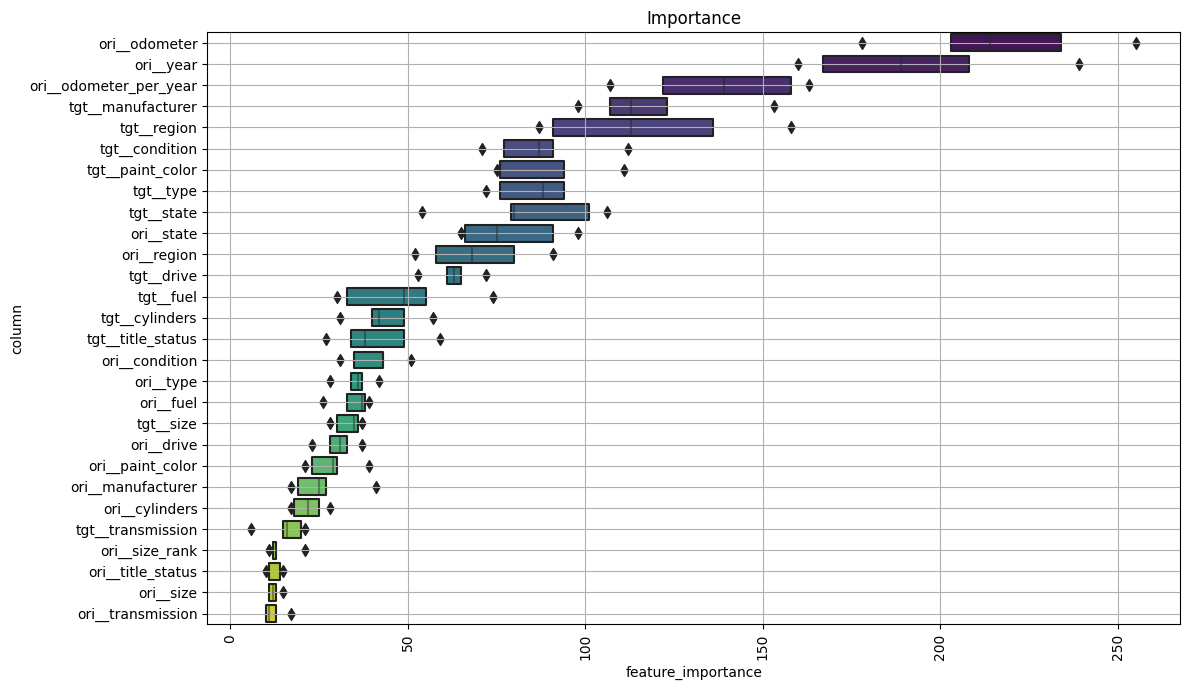

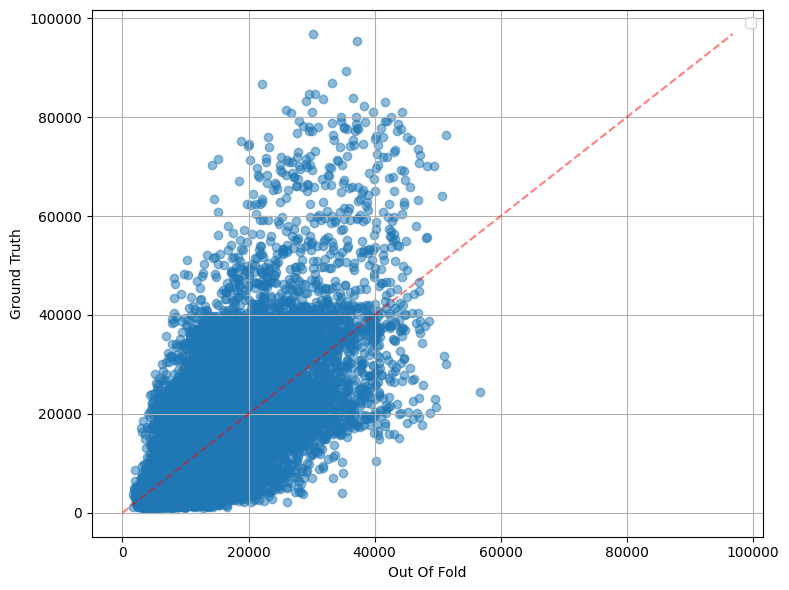

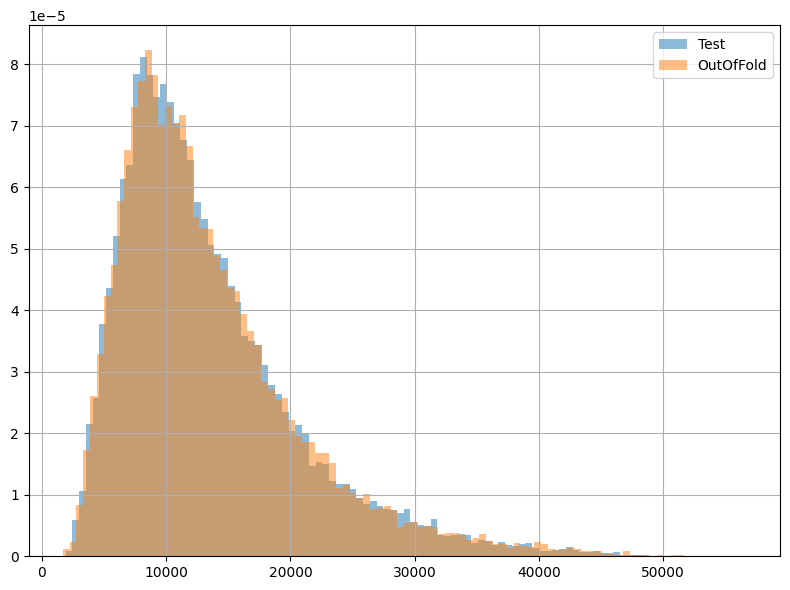

In [22]:
visualize_importance(models, train_feat_df)
visualize_oof_gt(oof, train_df['price'])
visualize_oof_pred(oof, pred)

In [23]:
df.isnull().sum()

id                 0
region             0
year               0
manufacturer       0
condition          0
cylinders          0
fuel            1239
odometer           0
title_status     456
transmission       0
drive              0
size               0
type             456
paint_color        0
state           3304
price              0
dtype: int64

In [24]:
train_df.isnull().sum()

id                      0
region                  0
year                    0
manufacturer            0
condition               0
cylinders              71
fuel                 1239
odometer                0
title_status            0
transmission            0
drive                   0
size                    0
type                  456
paint_color             0
state                3304
price                   0
size_rank               0
odometer_per_year       0
dtype: int64

In [25]:
test_df.isnull().sum()

id                      0
region                  0
year                    0
manufacturer            0
condition               0
cylinders              78
fuel                 1495
odometer                0
title_status            0
transmission            0
drive                   0
size                    0
type                  229
paint_color             0
state                3029
size_rank               0
odometer_per_year       0
dtype: int64